In [1]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from scipy.interpolate import griddata
import pyproj
from pyproj import Transformer
from datetime import datetime, timedelta
import os, fnmatch, glob
import cmocean 
import rasterio
from rasterio.plot import show
import sys
sys.path.append('/home/maltem/miniforge3/envs/opendrift/lib/python3.11/site-packages')
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.models.windblow import WindBlow
import geopy.distance

/home/maltem/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:62: UserWarning: Pandas requires version '1.3.4' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
def findindex(alat,alon,plat,plon):
    #finding identical location of pos plat, plon in array alat[],alon[]
    abslat = np.abs(alat-plat)
    abslon = np.abs(alon-plon)
    c = np.maximum(abslon,abslat)
    x, y = np.where(c == np.min(c))
    #print(alats[x,y],alon[x,y])
    x=int(x)
    y=int(y)
   
    return (x,y)

def findindex_reg(alat,alon,plat,plon):

    x=np.argmin(np.abs(alon-plon))
    y=np.argmin(np.abs(alat-plat))
    return(x,y)


In [10]:
class Model_Trajectory:
    
    def __init__(self, modeltraj,modeleval,lat,lon,initime,no_seeds,radius_seeds):
        self.modeltraj = modeltraj
        self.modeleval = modeleval
        self.seedlat = lat
        self.seedlon = lon
        self.initime = initime
        self.no_seeds = no_seeds
        self.radius_seeds = radius_seeds
        
    def info(self):
        print ('Windtrajectory from ', self.modeltraj, "forecast evaluation of " ,self.modeleval)
        print ('Lon: ',self.seedlon); print ('Lat: ',self.seedlat); print ('Initial time: ',self.initime)

    # Produce winddrift trajectories        
    def makeWinddrift(self):
    
        o = WindBlow(loglevel=20)  
        self.traj_file = 'tmp_transfer.nc'
        
        if self.modeltraj=='MET-AROME':
        
            year = datetime.strftime(self.initime, '%Y')
            month = datetime.strftime(self.initime, '%m')
            day = datetime.strftime(self.initime, '%d')
        
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
            fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
            fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'

            reader_arome = reader_netCDF_CF_generic.Reader(fc_file)
            o.add_reader([reader_arome])
            o.seed_elements(self.seedlon, self.seedlat, radius=self.radius_seeds, number=self.no_seeds, time=reader_arome.start_time)
            o.run(steps=4*48, time_step=900, time_step_output=3600, outfile=self.traj_file)
 
    # Evaluate forecasts along calculated trajectories    
    def getModelTrajectoryForecast(self):
    
        inDomain=True
    
        # Retrieve the trajectory data from opendrift outputfile: 
        # --
        WindTraj = xr.open_mfdataset(self.traj_file)
        ttime = WindTraj.time
        tlat  = np.squeeze(np.array(WindTraj.lat))
        tlon  = np.squeeze(np.array(WindTraj.lon))
        tray  = np.squeeze(np.array(WindTraj.trajectory))
        print('Model ',self.modeleval); print('Number of trajectories',len(tray)); print('Number of time steps',len(tlat[0,:]))
    
        t2m=np.zeros((len(tray),len(tlat[0,:])));  sic=np.zeros((len(tray),len(tlat[0,:])))
        lat=np.zeros((len(tray),len(tlat[0,:])));  lon=np.zeros((len(tray),len(tlat[0,:])))
    
        WindTraj.close()
       
        year = datetime.strftime(self.initime, '%Y')
        month = datetime.strftime(self.initime, '%m')
        day = datetime.strftime(self.initime, '%d')
    
        if self.modeleval=='ECMWF-IFS':
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/ECMWF-IFS/'
            fc_file = fc_data_path + 'Arctic.ECMWF_extracted_'+year+month+day+'T00Z.nc'
            fc = xr.open_dataset(fc_file)
            
            for ens in range(len(tray)):        
                for i in range(len(tlat[0,:])):        
                    t2m[ens,i] = fc['T2M'].sel(time=date,lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                    sic[ens,i] = fc['CI'].sel(time=date,lat=tlat[ens,i],lon=tlon[ens,i],method='nearest')
                    lat[ens,i]=float(tlat[ens,i])
                    lon[ens,i]=float(tlon[ens,i]) 
            
            fc.close()
        
        if self.modeleval=='MF-AROME':
        
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MF-AROME/'
            fc_file = fc_data_path + 'AROME_SVALBARD_'+year+month+day+'0000_*'  
            fc = xr.open_dataset(fc_file)
    
        if self.modeleval=='MF-ARPEGE':
            
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MF-ARPEGE/'
            fc_file = fc_data_path + 'ARPEGE_SVALBARD_'+year+month+day+'0000_*'  
            fc = xr.open_dataset(fc_file)
    
    
        if self.modeleval=='MET-AROME':
            
            fc_data_path='/lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/'
            fc_data_path=fc_data_path + year +"/"+ month  +"/"+ day+"/" 
            fc_file = fc_data_path + 'arome_arctic_det_2_5km_'+year+month+day+'T00Z.nc'      
            fc = xr.open_dataset(fc_file)
        
            [imax,jmax] = np.shape(fc['latitude'])
        
            for ens in range(len(tray)):        
                for i in range(len(tlat[0,:])):
                    [ix,jx] = findindex(fc['latitude'],fc['longitude'],tlat[ens,i],tlon[ens,i]) 
                    if (ix==0 or jx == 0 or ix==imax or jx==jmax):
                        inDomain = False
                        #print ('Out of Domain',i)
                    else:
                        inDomain= True         
                    if (inDomain):      
                        fctime = fc.sel(time=ttime[i],method='nearest')
                        t2m_nc = fctime['air_temperature_2m'].isel(y=ix, x=jx)
                        sic[ens,i]=float(fctime['SFX_SIC'].isel(y=ix, x=jx))
                        t2m[ens,i]=float(t2m_nc.values)
                        lat[ens,i]=float(tlat[ens,i])
                        lon[ens,i]=float(tlon[ens,i]) 
                    else:
                        t2m[ens,i]=np.nan
                        lat[ens,i]=np.nan
                        lon[ens,i]=np.nan
            fc.close()
    
        self.time = WindTraj.time
        self.lat  = lat
        self.lon  = lon
        self.t2m  = np.array(t2m)
        self.sic  = np.array(sic)
            
    def getBuoyCollocations(self,leadno):
            
        ensno  = len(self.lat[:,0])
        t2m_buoys=np.zeros((ensno,leadno)); t2m_buoys=t2m_buoys*np.nan
        
        #Load OMB data
        OMBraw = xr.open_mfdataset('/home/maltem/work/python/SvalMIZ2024/data/cruise/2024_KVS_deployment.nc')        
        
        # Loop over all trajectories and find observations close-by
        for ti in range(leadno): # Only the first leadno hours of the forecast
            timenow=self.time[ti]     
            for ens in range(len(self.lat[:,0])):
                timemask = np.int32(np.abs(np.array(OMBraw.time-timenow)).astype('timedelta64[m]'))<15
                for buoy_no in range(np.min(np.shape(timemask))):
                    tb = np.where(timemask[buoy_no,:])
                    if tb[0]:
                    # Buoy Coordinates
                        latb = np.array(OMBraw.lat[buoy_no,np.array(tb[0])])
                        lonb = np.array(OMBraw.lon[buoy_no,np.array(tb[0])])
                        # Trajectory Coordinates / ensemblermember&time - dependent
                        # lon[ens,ti];lat[ens,ti]
                
                        coords_1 = (latb, lonb)
                        coords_2 = (self.lat[ens,ti],self.lon[ens,ti])
                        if ~np.isnan(coords_2)[0]:
                            if geopy.distance.geodesic(coords_1, coords_2).km < 5: 
                                t2m_buoys[ens,ti] = np.array(OMBraw.temp_1m_calibrated[buoy_no,np.array(tb[0])])
        self.t2m_buoys=t2m_buoys
    
                        
    def plot_forecasts(self,leadno):
        fig, ax = plt.subplots(figsize=(8, 4),nrows=2,ncols=1)
        for ens in range(len(self.lat[:,0])):
            ax[1].plot(self.time[0:leadno],self.sic[ens,0:leadno],marker='.',linewidth=0.2,color='k')
            ax[0].plot(self.time[0:leadno],self.t2m[ens,0:leadno]-273.15,linewidth=0.2,color='k'),
            ax[0].scatter(self.time[0:leadno],self.t2m_buoys[ens,:],marker='*',s=10,color='r')
            ax[0].scatter(self.time[0:leadno],self.t2m_buoys[ens,:],marker='o',s=10,color='r')

In [17]:
#date = datetime.strptime('2024-04-12 10:00:00','%Y-%m-%d %H:%M:%S') 
#m1 = Model_Trajectory('MET-AROME','MET-AROME',79.94,17.7,date,20,2500)

#date = datetime.strptime('2024-04-14 10:00:00','%Y-%m-%d %H:%M:%S') 
#m1 = Model_Trajectory('MET-AROME','MET-AROME',80.28,15.1,date,20,2500)

date = datetime.strptime('2024-04-15 10:00:00','%Y-%m-%d %H:%M:%S') 
m1 = Model_Trajectory('MET-AROME','MET-AROME',80.95,15,date,20,2500)

m1.info()


Windtrajectory from  MET-AROME forecast evaluation of  MET-AROME
Lon:  15
Lat:  80.95
Initial time:  2024-04-15 10:00:00


In [18]:
m1.makeWinddrift()

15:17:20 INFO    opendrift.models.basemodel:515: OpenDriftSimulation initialised (version 1.11.13 / v1.11.13-11-gfa23a9f)
15:17:20 INFO    opendrift.readers.reader_netCDF_CF_generic:102: Opening dataset: /lustre/storeB/project/nwp/SALIENSEAS/SvalMIZ2024/models/MET_AROMEArctic/AROME_ARCTIC/2024/04/15/arome_arctic_det_2_5km_20240415T00Z.nc
15:17:40 INFO    opendrift.readers.reader_netCDF_CF_generic:314: Detected dimensions: {'time': 'time', 'x': 'x', 'y': 'y'}
15:17:40 INFO    opendrift.models.basemodel:2038: 2024-04-15 00:00:00 - step 1 of 192 - 20 active elements (0 deactivated)
15:17:41 INFO    opendrift.models.basemodel:2038: 2024-04-15 00:15:00 - step 2 of 192 - 20 active elements (0 deactivated)
15:17:41 INFO    opendrift.models.basemodel:2038: 2024-04-15 00:30:00 - step 3 of 192 - 20 active elements (0 deactivated)
15:17:41 INFO    opendrift.models.basemodel:2038: 2024-04-15 00:45:00 - step 4 of 192 - 20 active elements (0 deactivated)
15:17:41 INFO    opendrift.models.basemodel:2

15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 15:45:00 - step 64 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 16:00:00 - step 65 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 16:15:00 - step 66 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 16:30:00 - step 67 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 16:45:00 - step 68 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 17:00:00 - step 69 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 17:15:00 - step 70 of 192 - 20 active elements (0 deactivated)
15:17:45 INFO    opendrift.models.basemodel:2038: 2024-04-15 17:30:00 - step 71 of 192 - 20 active elements (0 deactivated)
15:17:45

15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 08:15:00 - step 130 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 08:30:00 - step 131 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 08:45:00 - step 132 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 09:00:00 - step 133 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 09:15:00 - step 134 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 09:30:00 - step 135 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 09:45:00 - step 136 of 192 - 20 active elements (0 deactivated)
15:17:49 INFO    opendrift.models.basemodel:2038: 2024-04-16 10:00:00 - step 137 of 192 - 20 active elements (0 deactivated)


In [19]:
m1.getModelTrajectoryForecast()

Model  MET-AROME
Number of trajectories 20
Number of time steps 49


In [20]:
m1.getBuoyCollocations(24)

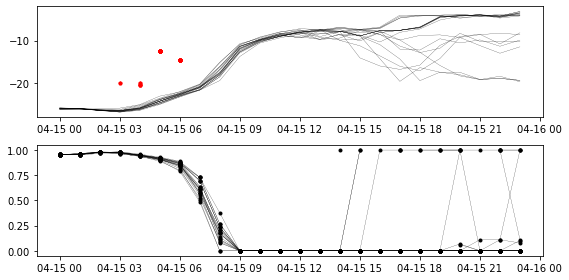

In [21]:
m1.plot_forecasts(24)

Windtrajectory from  MET-AROME forecast evaluation of  ECMWF-IFS
Lon:  17.7
Lat:  79.94
Initial time:  2024-04-15 10:00:00
Model  ECMWF-IFS
Number of trajectories 20
Number of time steps 49


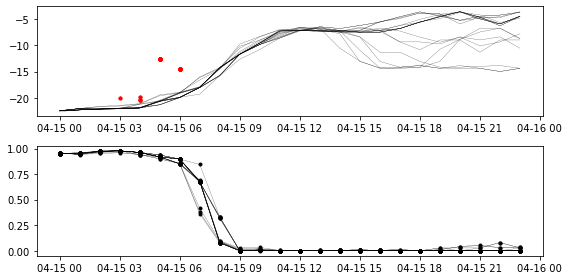

In [22]:
m2 = Model_Trajectory('MET-AROME','ECMWF-IFS',79.94,17.7,date,20,2500)
m2.info()
m2.traj_file = 'tmp_transfer.nc'
#m2.makeWinddrift()
m2.getModelTrajectoryForecast()
m2.getBuoyCollocations(24)
m2.plot_forecasts(24)